In [1]:
import sys
sys.path.append("./../common/")
from utils import *
from config import *
checkpoint_dir = '../models/RNN_checkpoints'

# configuring to be deterministic for reproducibility
tf.keras.utils.set_random_seed(RND_SEED)
tf.config.experimental.enable_op_determinism()

In [2]:
def build_train_RNN(x_train, y_train, epochs, verbose=False):
    # build NN
    z = np.log(np.expm1(1.))
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(4),
        tfp.layers.DenseVariational(units=2,
                            make_prior_fn=common_prior,
                            make_posterior_fn=common_posterior,
                            kl_weight=1/x_train.size,
                            kl_use_exact=False),
        tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Normal(loc=t[..., :1],
                                    scale=1e-3 + 0.1*tf.nn.softplus(z + t[..., 1:])
                                    )
                )
    ])

    model.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=1e-3))

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)

    # train NN
    if verbose:
        model.fit(x_train, y_train, epochs=epochs, verbose=0, callbacks=[print_every_n_epochs(100), model_checkpoint_callback])
    else:
        model.fit(x_train, y_train, epochs=epochs, verbose=0, callbacks=[model_checkpoint_callback])
    model.load_weights(checkpoint_dir)
    return model

def get_RNN_output(model, x, K):
    means = []
    vars = []
    for _ in range(K):
        sample_output = model(x)
        means.append(np.squeeze(sample_output.mean()))
        vars.append(np.squeeze(sample_output.variance()))
    
    y_hat = np.array(means).mean(axis=0)
    sd_hat = np.sqrt(np.array(means).var(axis=0) + np.array(vars).mean(axis=0))
    return y_hat, sd_hat

def create_dataset(years, test_years):
    m, c = 0.2, 0.1
    sd_e = 0.5

    def create_seasons(years):
        mid = 183
        x_year_first_half  = np.arange(0, mid)
        x_year_second_half  = np.arange(mid, 365)
        y_year_first_half = m*x_year_first_half + c + np.random.normal(0, sd_e, mid)
        y_year_second_half = -m*(x_year_second_half - 365) + c + np.random.normal(0, sd_e, mid-1)
        seasons = np.concatenate((y_year_first_half, y_year_second_half))
        for _ in range(years - 1):
            y_year_first_half = m*x_year_first_half + c + np.random.normal(0, sd_e, mid)
            seasons = np.concatenate((seasons, y_year_first_half))
            y_year_second_half = -m*(x_year_second_half - 365) + c + np.random.normal(0, sd_e, mid-1)
            seasons = np.concatenate((seasons, y_year_second_half))
        return seasons[:, np.newaxis]

    train_size = (years) * 365
    x_train = np.arange(0, train_size)[:, np.newaxis]
    y_train = create_seasons(years)

    test_size = (test_years) * 365
    x_test = np.arange(train_size, train_size + test_size)[:, np.newaxis]
    y_test = create_seasons(test_years)

    return [x_train, y_train], [x_test, y_test]

def prepare_dataset(dataset, window, ahead):
    x, y = [], []
    for i in range(len(dataset)-window-1-ahead):
        x.append([dataset[i:i+window, 0]])
        y.append([dataset[i+window+ahead-1, 0]])
    x, y = np.array(x), np.array(y)
    return x, y

class print_every_n_epochs(tf.keras.callbacks.Callback):
    def __init__(self, n):
        self.n = n
    
    def on_epoch_end(self, epoch, logs=None):
        if(int(epoch) % self.n) == 0:
            print("epoch: {} - loss: {}".format(epoch, logs['loss']))

In [3]:
K = 100
window = 28
days_ahead = 7
years = 5
test_years = 5
epochs = 2500

train, test = create_dataset(years, test_years)
TIME, SERIES = 0, 1

x_train, y_train = prepare_dataset(train[SERIES], window, days_ahead)
x_test, y_test = prepare_dataset(test[SERIES], window, days_ahead)

model = build_train_RNN(x_train, y_train, epochs)
y_hat, sd_hat = get_RNN_output(model, x_test, K)


2023-04-25 15:38:48.316981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


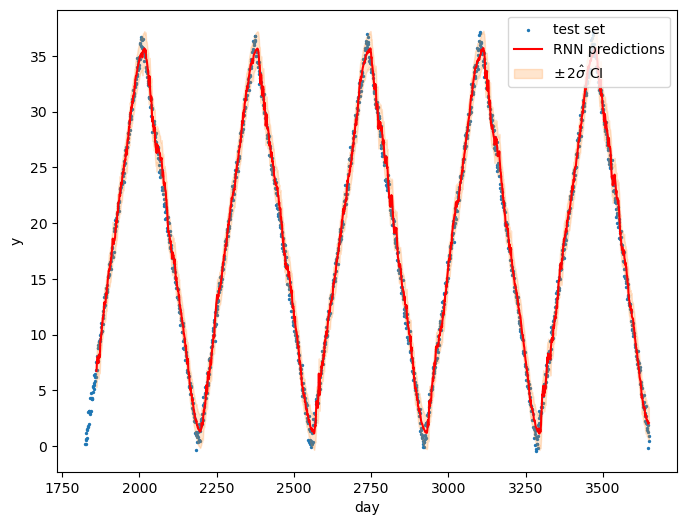

In [4]:
# plot predictions and CIs
fig = plt.figure()
plt.scatter(test[TIME], test[SERIES], s=2, label='test set')
plt.plot(test[TIME][window+1+days_ahead:], y_hat, c='r', label='RNN predictions')
ci_lower = y_hat - 2 * sd_hat
ci_upper = y_hat + 2 * sd_hat
plt.fill_between(np.squeeze(test[TIME][window+1+days_ahead:]), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ CI', color='C1')
save_xy_graph(fig, 'day', 'y', figures_dir, 'rnn_ci_test.png')

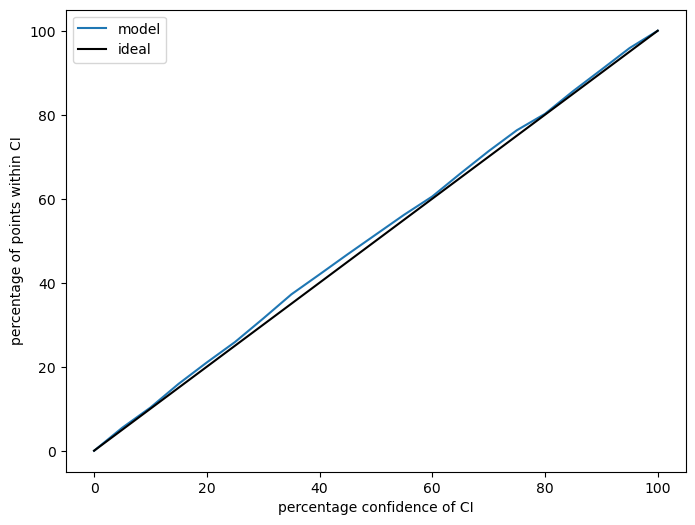

In [6]:
# plot uncertainty calibration
confidences = get_confidence_axis()
in_range = unc_calibration(y_test, y_hat, sd_hat)
fig = plt.figure()
plt.plot(confidences, in_range, label="model")
plt.plot([0,100], [0,100], label="ideal", c="black")
save_xy_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'rnn_calibration.png')

In [6]:
gammas = [7,14,21,28]
models = {}

for gamma in gammas:
    print(gamma)
    x_train, y_train = prepare_dataset(train[SERIES], window, gamma)
    x_test, y_test = prepare_dataset(test[SERIES], window, gamma)

    model = build_train_RNN(x_train, y_train, epochs)
    models[str(gamma)] = model

7
14
21
28


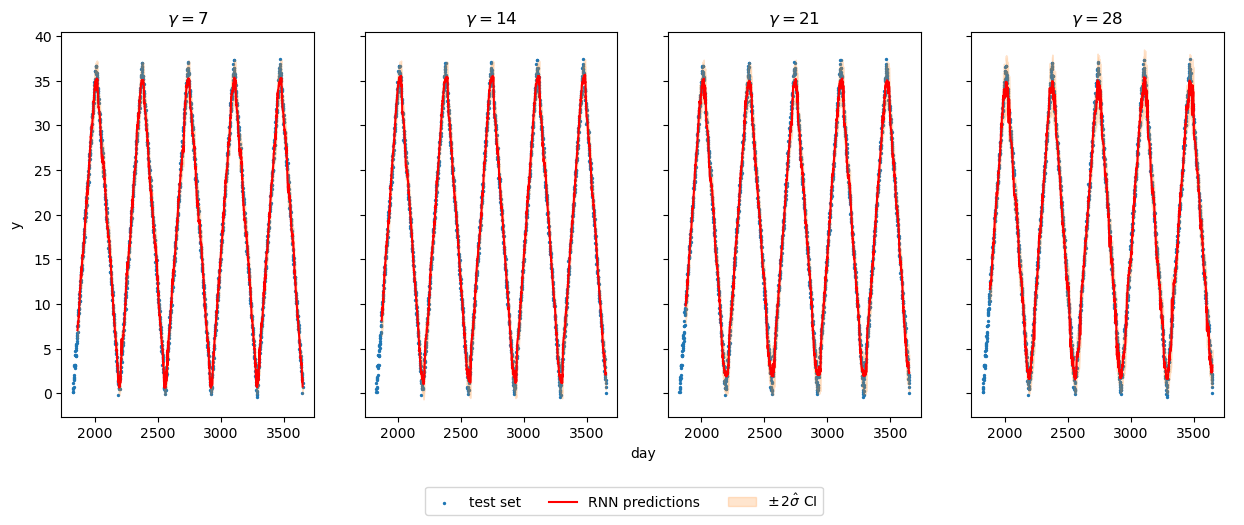

In [7]:
fig, axs = plt.subplots(1, len(gammas), figsize=(15, 5), sharey=True)
idx = 0
for gamma in gammas:
    model = models[str(gamma)]
    x_test, y_test = prepare_dataset(test[SERIES], window, gamma)
    y_hat, sd_hat = get_RNN_output(model, x_test, K)

    # plot predictions and CIs
    axs[idx].scatter(test[TIME], test[SERIES], s=2, label='test set')
    axs[idx].plot(test[TIME][window+1+gamma:], y_hat, c='r', label='RNN predictions')
    ci_lower = y_hat - 2 * sd_hat
    ci_upper = y_hat + 2 * sd_hat
    axs[idx].fill_between(np.squeeze(test[TIME][window+1+gamma:]), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ CI', color='C1')
    axs[idx].set_title('$\gamma = {}$'.format(gamma))

    idx += 1

save_multiplot_graph(fig, 'day', 'y', figures_dir, 'rnn_gamma_ci.png', labels=['test set', 'RNN predictions', '$\pm\,2\hat\sigma$ CI'])

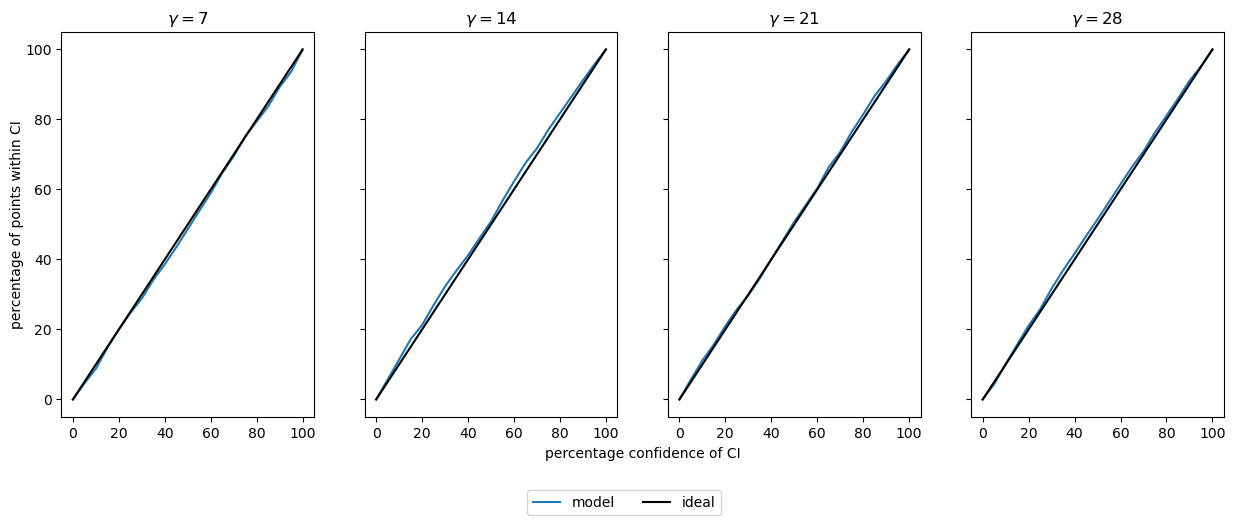

In [8]:
fig, axs = plt.subplots(1, len(gammas), figsize=(15, 5), sharey=True)
idx = 0
for gamma in gammas:
    model = models[str(gamma)]
    x_train, y_train = prepare_dataset(train[SERIES], window, gamma)
    x_test, y_test = prepare_dataset(test[SERIES], window, gamma)
    y_hat, sd_hat = get_RNN_output(model, x_test, K)

    # plot uncertainty calibration
    confidences = get_confidence_axis()
    in_range = unc_calibration(y_test, y_hat, sd_hat)
    axs[idx].plot(confidences, in_range, label="model")
    axs[idx].plot([0,100], [0,100], label="ideal", c="black")
    axs[idx].set_title('$\gamma = {}$'.format(gamma))

    idx += 1

save_multiplot_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'rnn_gamma_calibration.png', labels=['model', 'ideal'])